# Parameter identification interface
### User-interface to perform parameter identification of bioscrape/SBML models

* Simple functions to import models/data 
* Use the fast deterministic and stochastic simulators available within bioscrape
* (Optionally) Specify paramter priors, desired likelihood/cost functions 
* Create your own likelihood functions interface

## Loglikelihood Functions
Bioscrape comes with a number of built in log-likelihood functions for deterministic or stochastic parameter inference. These functions are detailed in the following notebook. First, a simple model is made to test the functions:

$\emptyset \xrightarrow[]{k_1} X \; \; \; \; X \xrightarrow[]{d_1} \emptyset$

A set of N trajectories is then generated from this model, from either the same or different initial conditions, across the same or different time-windows. Gaussian noise is then added to all the samples.

In [2]:
%matplotlib inline
import bioscrape as bs
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model

import numpy as np
import pylab as plt

# Import bioscrape XML / bioscrape model object M / SBML file
# M  = bs.types.read_model_from_sbml(filename)
# M = Model('models/pid_model.xml')

# Or...Create a Model using the bioscrape API
species = ['X']
reactions = [(['X'], [], 'massaction', {'k':'d1'}), ([], ['X'], 'massaction', {'k':'k1'})]
k1 = 10.0
d1 = .2
params = [('k1', k1), ('d1', d1)]
initial_condition = {'X':0}
M = Model(species = species, reactions = reactions, parameters = params, 
          initial_condition_dict = initial_condition)


# Import data from CSV
# data = import_timeseries('test_data.csv', time_column = 2, value_column = 4, properties = {3 : 51})

M.py_initialize()

N = 10 #Number of trajectories
nT = 50 #number of timepoints
noise_std = 5 #Standar deviation of the guassian noise added onto the measurements

MultipleTimepoints = True #Different timepoints for each trajectory?
timepoint_list = []
timepoints = np.linspace(np.random.randint(0, 10), np.random.randint(10, 100), nT)
#Generate Trajectories
R = [] #Results as Pandas Dataframes
data = [] #Results will become a numpy array
MultipleInitialConditions = True #Different initial conditions for each trajectory?

X0_list = [] #multiple initial conditions will be saved for inference
for n in range(N):
    if MultipleInitialConditions:
        initial_condition = {'X': np.random.randint(0, 100)}
        X0_list.append(initial_condition)
        
    if MultipleTimepoints:
        timepoints = np.linspace(np.random.randint(0, 10, 1), np.random.randint(10, 100, 1), num = 50).flatten()
        timepoint_list.append(timepoints)
    
    M.set_species(initial_condition)
    r = py_simulate_model(timepoints, Model = M, stochastic = True)
    R.append(r)
    noisy_data = r['X'].to_numpy() + np.random.normal(loc = 0, scale = noise_std, size = nT)
    data.append(noisy_data)


In [3]:
M.get_parameter_values()

array([ 0.2, 10. ])

### To run the MCMC algorithm to identify parameters from the data, the following code can be used.

Sample log-like: 3558.2809000762827
Sample log-like: 3556.8236410600935
Sample log-like: 3557.5358713887313
Sample log-like: 3558.0002033569053
Sample log-like: 3558.5614799891696
Sample log-like: 3558.2467151493292
Sample log-like: 3558.609934494205
Sample log-like: 3558.666129187676
0.0 percent complete
50.0 percent complete
Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file


c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\emcee\ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\emcee\ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


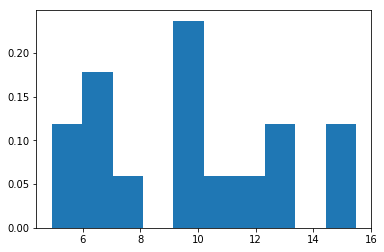

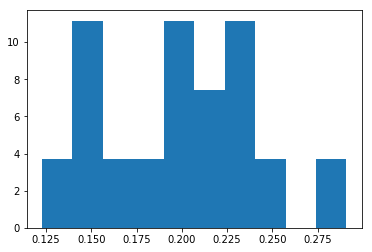

ValueError: setting an array element with a sequence.

In [4]:
# Run parameter identification procedure using Python emcee -
from bioscrape.pid_interfaces import *
from bioscrape.emcee_interface import *

pid = initialize_mcmc()
pid.exp_data = np.array(data)
pid.M = M
pid.prior = {'k1' : [1e-3, 1e3],'d1' : [1e-2, 1e5]}
pid.params_to_estimate = {'k1':10, 'd1':0.2}
pid.type = 'stochastic'
pid.timepoints = timepoint_list
pid.initial_conditions = X0_list
pid.nsamples = 5
pid.nsteps = 2
pid.nwalkers = 8
fitted_model, params = pid.run_mcmc(plot_show = True)

In [27]:
params

{'k1': array([ 9.50323215, 10.62809759]), 'd1': array([0.18749789])}

In [28]:
M.parameters

AttributeError: 'bioscrape.types.Model' object has no attribute 'parameters'